<font size=5><b>**Тестовое задание**</b></font>
    
<font size=4><b>**Задача 2. Прогноз среднесуточных цен**</b></font>

# Задание

Необходимо, используя данные из выданных файлов, сделать прогноз среднесуточных цен на электроэнергию по ЦЗ «Европа» на месяц вперед (30 суток).

# Загрузка

Сперва подготовим окружение, загрузив необходимые библиотеки.

In [1]:
# Автоформатирование
try:
    %load_ext lab_black
except:
    None

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    cross_validate,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
try:
    from prophet import Prophet
except Exception:
    !pip install prophet
    from prophet import Prophet

In [5]:
try:
    from catboost import CatBoostRegressor, Pool
except Exception:
    !pip install catboost
    from catboost import CatBoostRegressor, Pool

In [6]:
try:
    import phik
except Exception:
    ! pip install phik
    import phik

In [7]:
try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna

Загрузим сами данные, которые располагаются в трех файлах Excel, разделенных по годам.

In [8]:
df_2018 = pd.read_excel("Данные 2018 год.xlsx", parse_dates=[0])
df_2019 = pd.read_excel("Данные 2019 год.xlsx", parse_dates=[0])
df_2020 = pd.read_excel("Данные 2020 год.xlsx", parse_dates=[0])

# Обзор данных

Выведем общую информацию о загруженных таблицах.

In [9]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131400 entries, 0 to 131399
Data columns (total 18 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Дата                                              131400 non-null  datetime64[ns]
 1   ЦЗ                                                131400 non-null  object        
 2   ЗСП                                               131400 non-null  object        
 3   Час                                               131400 non-null  int64         
 4   План ГЭС, МВт*ч                                   131400 non-null  float64       
 5   План АЭС, МВт*ч                                   131400 non-null  float64       
 6   План ТЭС, МВт*ч                                   131400 non-null  float64       
 7   ТЭС мин, МВт*ч                                    131400 non-null  float64       
 8   ТЭС макс, МВт*

In [10]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131400 entries, 0 to 131399
Data columns (total 18 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Дата                                              131400 non-null  datetime64[ns]
 1   ЦЗ                                                131400 non-null  object        
 2   ЗСП                                               131400 non-null  object        
 3   Час                                               131400 non-null  int64         
 4   План ГЭС, МВт*ч                                   131400 non-null  float64       
 5   План АЭС, МВт*ч                                   131400 non-null  float64       
 6   План ТЭС, МВт*ч                                   131400 non-null  float64       
 7   ТЭС мин, МВт*ч                                    131400 non-null  float64       
 8   ТЭС макс, МВт*

In [11]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85320 entries, 0 to 85319
Data columns (total 18 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Дата                                              85320 non-null  datetime64[ns]
 1   ЦЗ                                                85320 non-null  object        
 2   ЗСП                                               85320 non-null  object        
 3   Час                                               85320 non-null  int64         
 4   План ГЭС, МВт*ч                                   85320 non-null  float64       
 5   План АЭС, МВт*ч                                   85320 non-null  float64       
 6   План ТЭС, МВт*ч                                   85320 non-null  float64       
 7   ТЭС мин, МВт*ч                                    85320 non-null  float64       
 8   ТЭС макс, МВт*ч           

Таблицы для 2018 и 2019 годов одинакового размера, в то время как таблица для 2020 года - содержит на 35% меньше данных. 
Пропусков в данных отсутсвуют, что хорошо.

Все столбцы названы кирилицей, что может быть неудобно при дальнейшей работе с данными.
В этой связи изменим названия столбцов.

In [12]:
columns_list = [
    "date",
    "cost_zone",
    "free_overflow_zone",
    "hour",
    "hes_plan",
    "nes_plan",
    "tes_plan",
    "tes_min",
    "tes_max",
    "consumption",
    "export",
    "import",
    "ses_plan",
    "wes_plan",
    "res_plan",
    "offer",
    "extra_offer",
    "cost",
]

df_2018.columns = columns_list
df_2019.columns = columns_list
df_2020.columns = columns_list

Выведем первые 5 строк первой таблицы.

In [13]:
df_2018.head()

date   cost_zone free_overflow_zone  hour  hes_plan  nes_plan  \
0 2018-01-01  Европа             FZUROE07       8     145.6     616.0   
1 2018-01-01  Европа             FZURTU08       8       0.0       0.0   
2 2018-01-01  Европа             FZVLBS15       8     120.0    4073.0   
3 2018-01-01  Европа             FZVLOE13       8     500.0      49.5   
4 2018-01-01  Европа             FZYUAS18       8       0.0       0.0   

    tes_plan    tes_min    tes_max  consumption    export    import  ses_plan  \
0  15310.118  12985.703  18417.555    16133.167  1724.097  2122.273       8.3   
1  11906.500   8014.692  12166.200     9971.934  1658.871    29.774       0.0   
2    576.000    576.000    640.000     1375.474  3260.660     1.122       0.6   
3   3857.360   3777.730   4461.390     5812.795  1369.469  2873.540       0.0   
4    431.500    326.297    531.500      532.284    30.329   154.762       2.0   

   wes_plan  res_plan     offer  extra_offer    cost  
0       0.0         0  82858.55     6103.482  776.25  
1       0.0         0  82858.55     6103.482  685.40  
2       0.0         0  82858.55     6103.482  781.87  
3       3.5         0  82858.55     6103.482  823.30  
4       0.0         0  82858.55     6103.482  890.73

Бросается в глаза наличие данных для разных ЗСП в одну дату. 
Указанный факт в дальнейшем рассмотрим побробнее для установления стратегии создания моделей.

Для упрощения дальнейшего анализа и работы в целом, объединим три таблицы в один массив.

In [14]:
df = pd.concat([df_2018, df_2019, df_2020])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348120 entries, 0 to 85319
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                348120 non-null  datetime64[ns]
 1   cost_zone           348120 non-null  object        
 2   free_overflow_zone  348120 non-null  object        
 3   hour                348120 non-null  int64         
 4   hes_plan            348120 non-null  float64       
 5   nes_plan            348120 non-null  float64       
 6   tes_plan            348120 non-null  float64       
 7   tes_min             348120 non-null  float64       
 8   tes_max             348120 non-null  float64       
 9   consumption         348120 non-null  float64       
 10  export              348120 non-null  float64       
 11  import              348120 non-null  float64       
 12  ses_plan            348120 non-null  float64       
 13  wes_plan            348120 non

## ЗСП

Проверим количество ЗСП в каждой таблице и в итоговой.

In [16]:
df_2018["free_overflow_zone"].nunique()

15

In [17]:
df_2019["free_overflow_zone"].nunique()

15

In [18]:
df_2020["free_overflow_zone"].nunique()

15

In [19]:
df["free_overflow_zone"].nunique()

15

Количество ЗСП одинаковое во всех датасетах. 

При детальном рассмотрении данных обноружено, что ЗСП записаны с пробелами в конце.
Указанный факт создает определенные неудобства в обработки данных, в связи с чем введем обработку значений с удалением лишних пробелов.

In [20]:
df["free_overflow_zone"] = df["free_overflow_zone"].str.replace("  ", "")

Создадим список ЗСП, который пригодится для дальнейшего анализа.

In [21]:
foz_list = df["free_overflow_zone"].unique()
foz_list

array(['FZUROE07', 'FZURTU08', 'FZVLBS15', 'FZVLOE13', 'FZYUAS18',
       'FZYUDA23', 'FZYUKU20', 'FZYUOE16', 'FZYUVG17', 'FZZMSK26',
       'FZSZKO28', 'FZSZOE27', 'FZURKR12', 'FZZNOE24', 'FZURNT09'],
      dtype=object)

## Дата

В таблице содержится признак о часе формирования остальных признаков, который отделен от основной даты.
Выведем количество его уникальных значений и сами значения.

In [22]:
df["hour"].nunique()

24

In [23]:
np.sort(df["hour"].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

Признак содержит исключительно информацию о часе.
Объеденим его с признаком даты и перенесем в индекс датафрейма, что упростит построение графиков.

In [24]:
df["date"] = df["date"] + pd.to_timedelta(df["hour"], unit="h")
df = df.set_index("date")
df = df.sort_index()

Учитывая, что цена за электроэнергию может отличатся ночью и днем, создадим соответствующий признак. 

In [25]:
df["day_time"] = 1
df.loc[df["hour"] < 8, "day_time"] = 0

## Регион

Проверим количество уникальных значений для признака региона.

In [26]:
df["cost_zone"].nunique()

1

Для каждой строки только одно значения.
Таким образом, признак не может быть информативным для решения настоящей задачи и его следует исключить.

Одновременно исключим признак с часом, включенным в дату ранее.

In [27]:
df = df.drop(columns=["hour", "cost_zone"])

# Анализ данных

## Распределения целевого признака

Построим графики изменения цены электроэнергии во времени:
- по каждому ЗСП,
- по каждому ЗСП с осреднением в масштабе одного дня,
- по всему региону с осреднением в масштабе одного дня.

In [28]:
def cost_plots(df):
    """
    Функция получает на вход исходый датафрейм
    и строит 15 графиков - по одному на каждый ЗСП.
    Графики выводятся в формате субплота размерностью a x b.
    На каждом графике строятся:
    - исходные данные по каждому ЗСП,
    - исходные данные по каждому ЗСП с осреднением в масштабе одного дня,
    - исходные данные по всему региону с осреднением в масштабе одного дня.
    Для наглядности, графики строятся в одном масштабе по оси Y.
    """
    a = 5
    b = 3

    _, axs = plt.subplots(a, b, figsize=(16, 16))
    plt.subplots_adjust(hspace=0.7, wspace=0.3)

    for i in range(a):
        for j in range(b):
            # Выделяем и ресэмплируем данные
            data = df.loc[df["free_overflow_zone"] == foz_list[j + i * b], "cost"]
            data_res = data.resample("1D").mean()

            # Строим график
            data.plot(ax=axs[i, j], label="all data")
            data_res.plot(ax=axs[i, j], label="resample")
            df["cost"].resample("1D").mean().plot(
                label="Среднее по региону", ax=axs[i, j]
            )

            # Настройка графика
            axs[i, j].set_title(foz_list[j + i * b])
            axs[i, j].set_ylim(0, 6000)
            axs[i, j].set_ylabel("Цена продажи электроэнергии \n (руб./МВт*ч)")
            axs[i, j].set_xlabel("Дата")
            axs[i, j].legend()
            axs[i, j].grid(True)

            # Сохраняем результаты ресэмплирования для анализа
            costs[foz_list[j + i * b]] = [data_res.mean(), data_res.std()]

    plt.show()

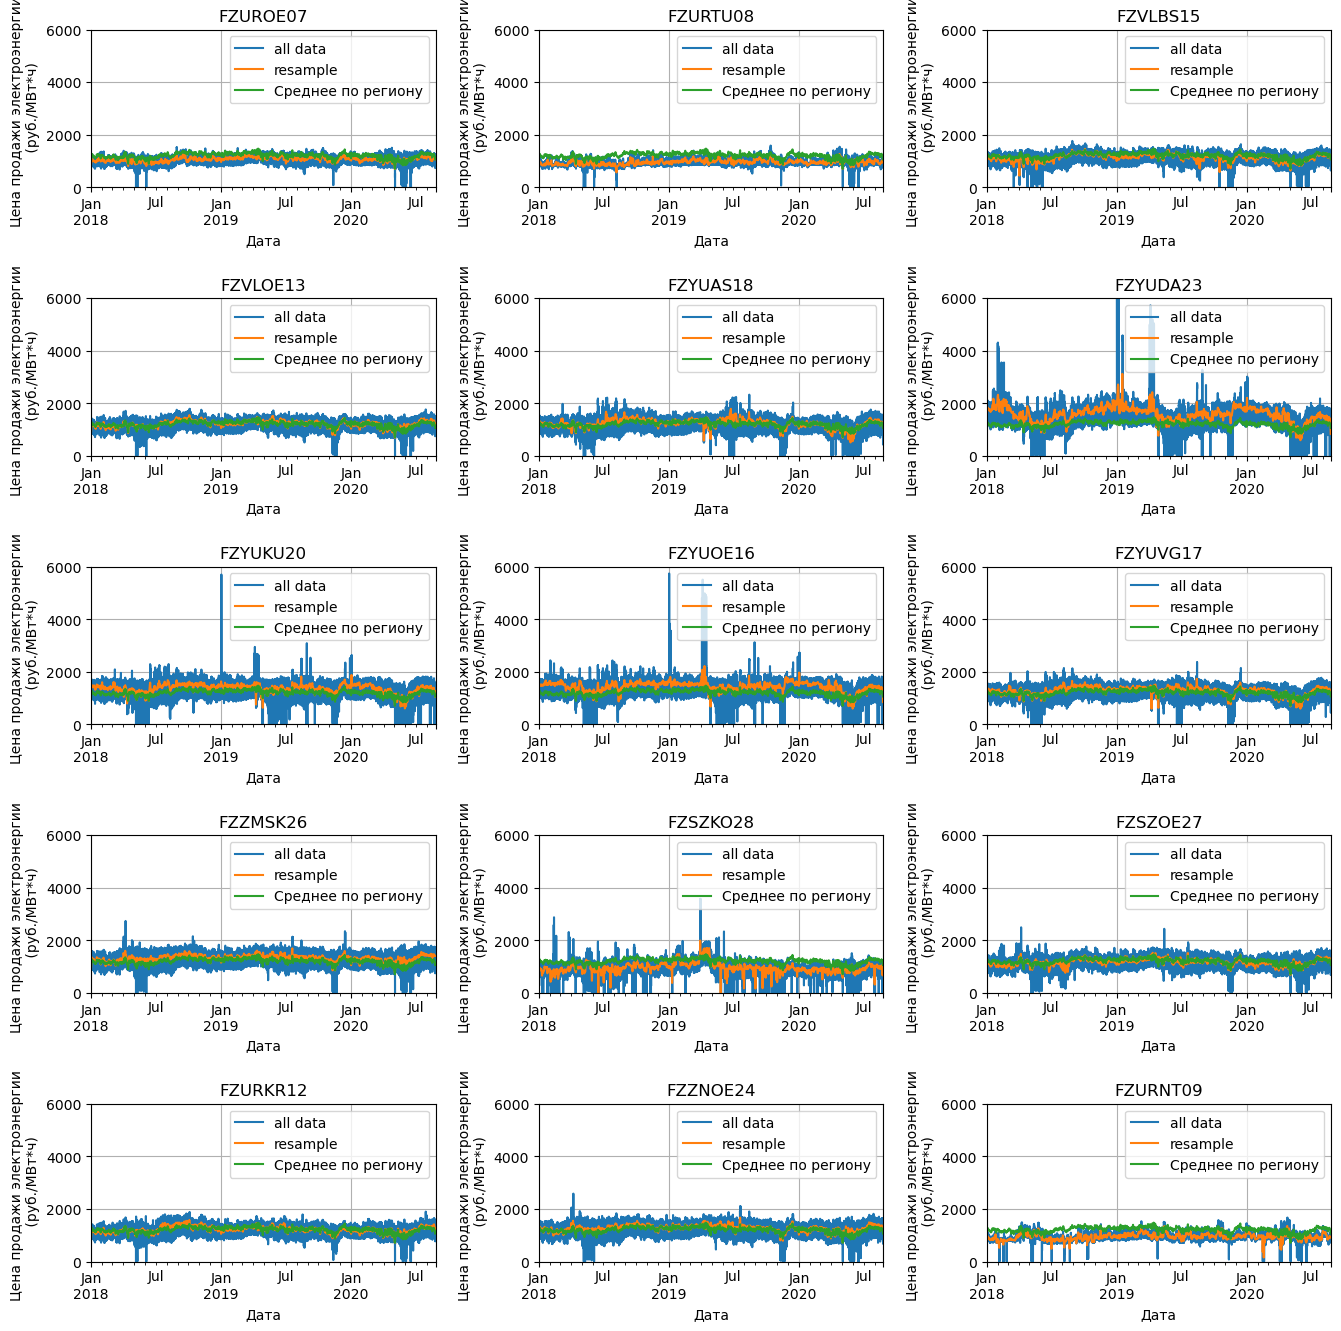

In [29]:
# Сохраняем результаты ресэмплирования по всему датафрейму
costs = {}
costs["region"] = [
    df["cost"].resample("1D").mean().mean(),
    df["cost"].resample("1D").mean().std(),
]

# Строим графики
cost_plots(df)

По графикам можно сделать следующие выводы.
- Среднее значение цены электроэнергии составляет примерно 1200 для всех ЗСП.
- Зоны 12 и 13 лучше всего повторяют динамику всего региона, а 9, 16, 23 и 28 - хуже всего. 
- Есть выбросы в масштабе зон - нулевые значения и более 4000. При этом нулевая цена обладает сезонностью и повторяется в июле.
- Зона 23 - самые сильные колебания цены.

Анализ поученных данных позволяет выделить два возможных направления решения поставленной задачи:
1) Прямое предсказание средней цены электроэнергии по региону.
2) Предсказание средней цены электроэнергии для каждого ЗСП с последующим их осреднением.

Интуитивно, второе направления кажется более перспективным, так как позволит учесть особенности каждой ЗСП.
Для выбора решения, основанного на данных, а не на интуции, рассмотрим распределения целевого признака и остальных более детально.

Посмотрим на распределения значений цены в разрезе по времени суток: день и ночь.

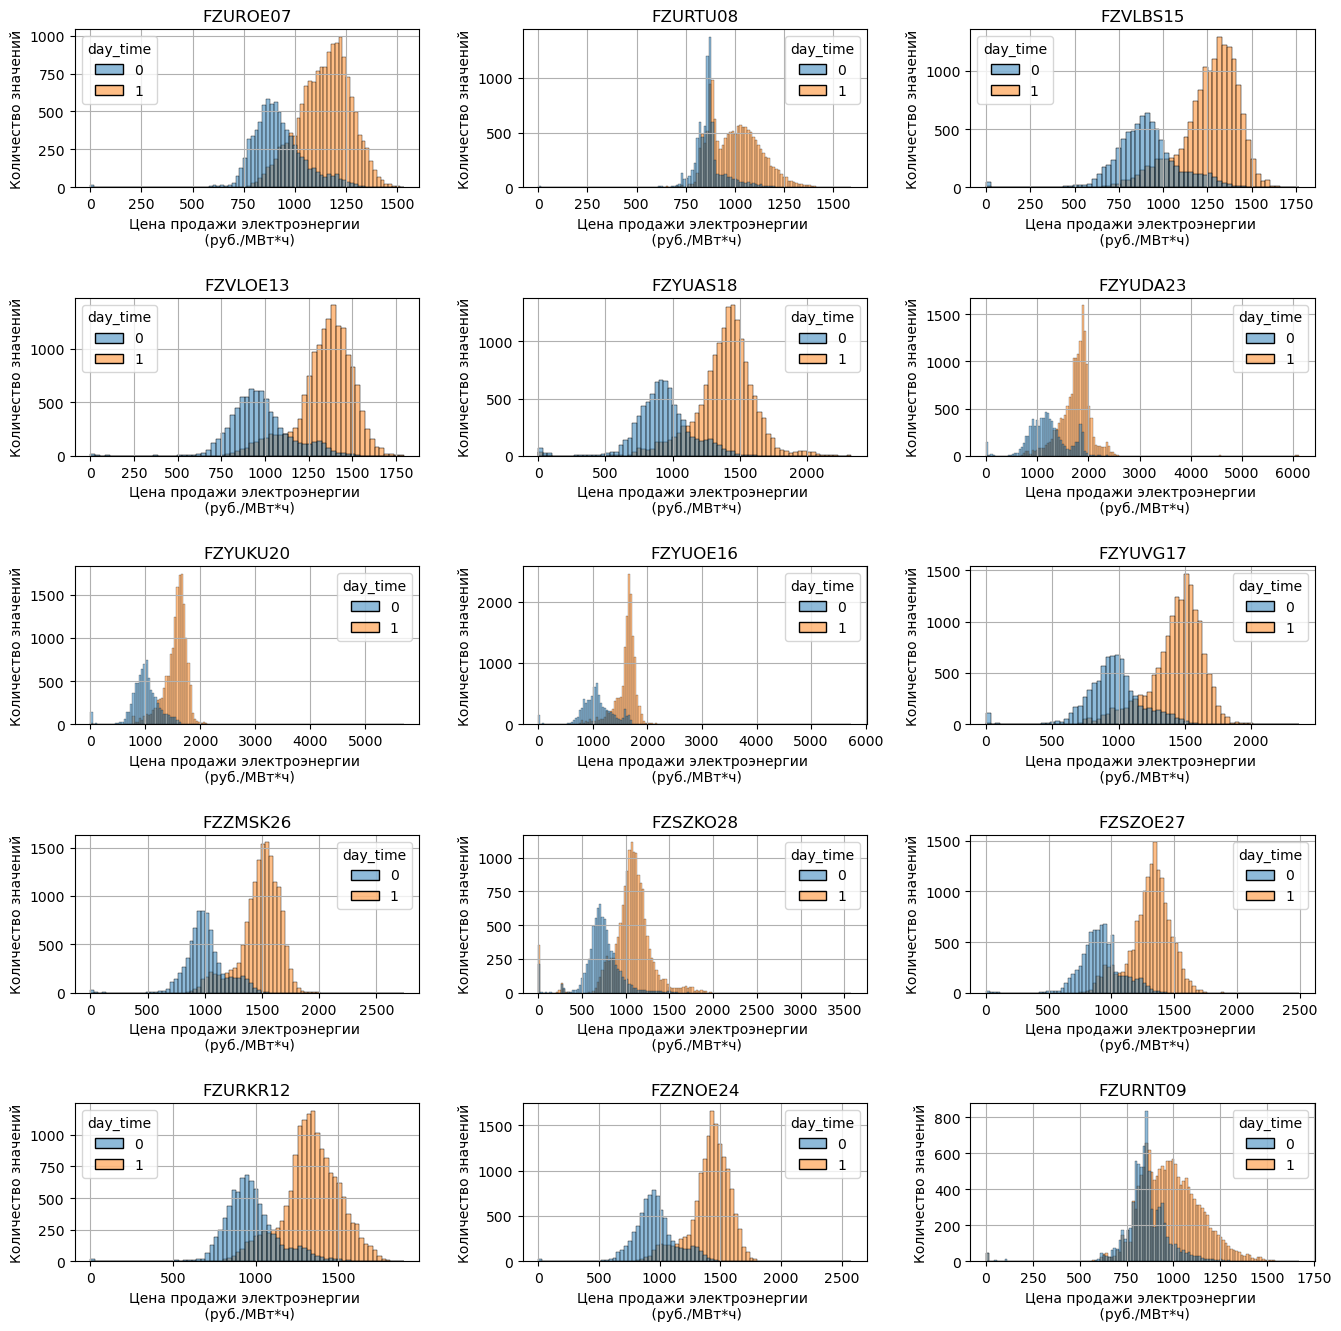

In [30]:
a = 5
b = 3

_, axs = plt.subplots(a, b, figsize=(16, 16))
plt.subplots_adjust(hspace=0.7, wspace=0.3)

for i in range(a):
    for j in range(b):
        sns.histplot(
            df[df["free_overflow_zone"] == foz_list[j + i * b]],
            x="cost",
            ax=axs[i, j],
            hue="day_time",
        )
        axs[i, j].set_title(foz_list[j + i * b])
        axs[i, j].set_ylabel("Количество значений")
        axs[i, j].set_xlabel("Цена продажи электроэнергии \n (руб./МВт*ч)")
        axs[i, j].grid(True)

plt.show()

По гистограммам хорошо прослеживается явное разделение значения цены от времени суток.
Отклонения от нормального распределения могут быть связаны с неточным выбором определения ночи от 0 часов до 8 или со сдвигом, обусловленным часовым поясом, об учете которого нет информации в условии задачи.

Примичательно, что зоны 08 и 09 имеют потребление ночью выше, чем днем. 
Остальные зоны больше потребляют днем.

Посмотрим, как разделение на время суток выглядит на временной шкале, построив графики для ночного периода.

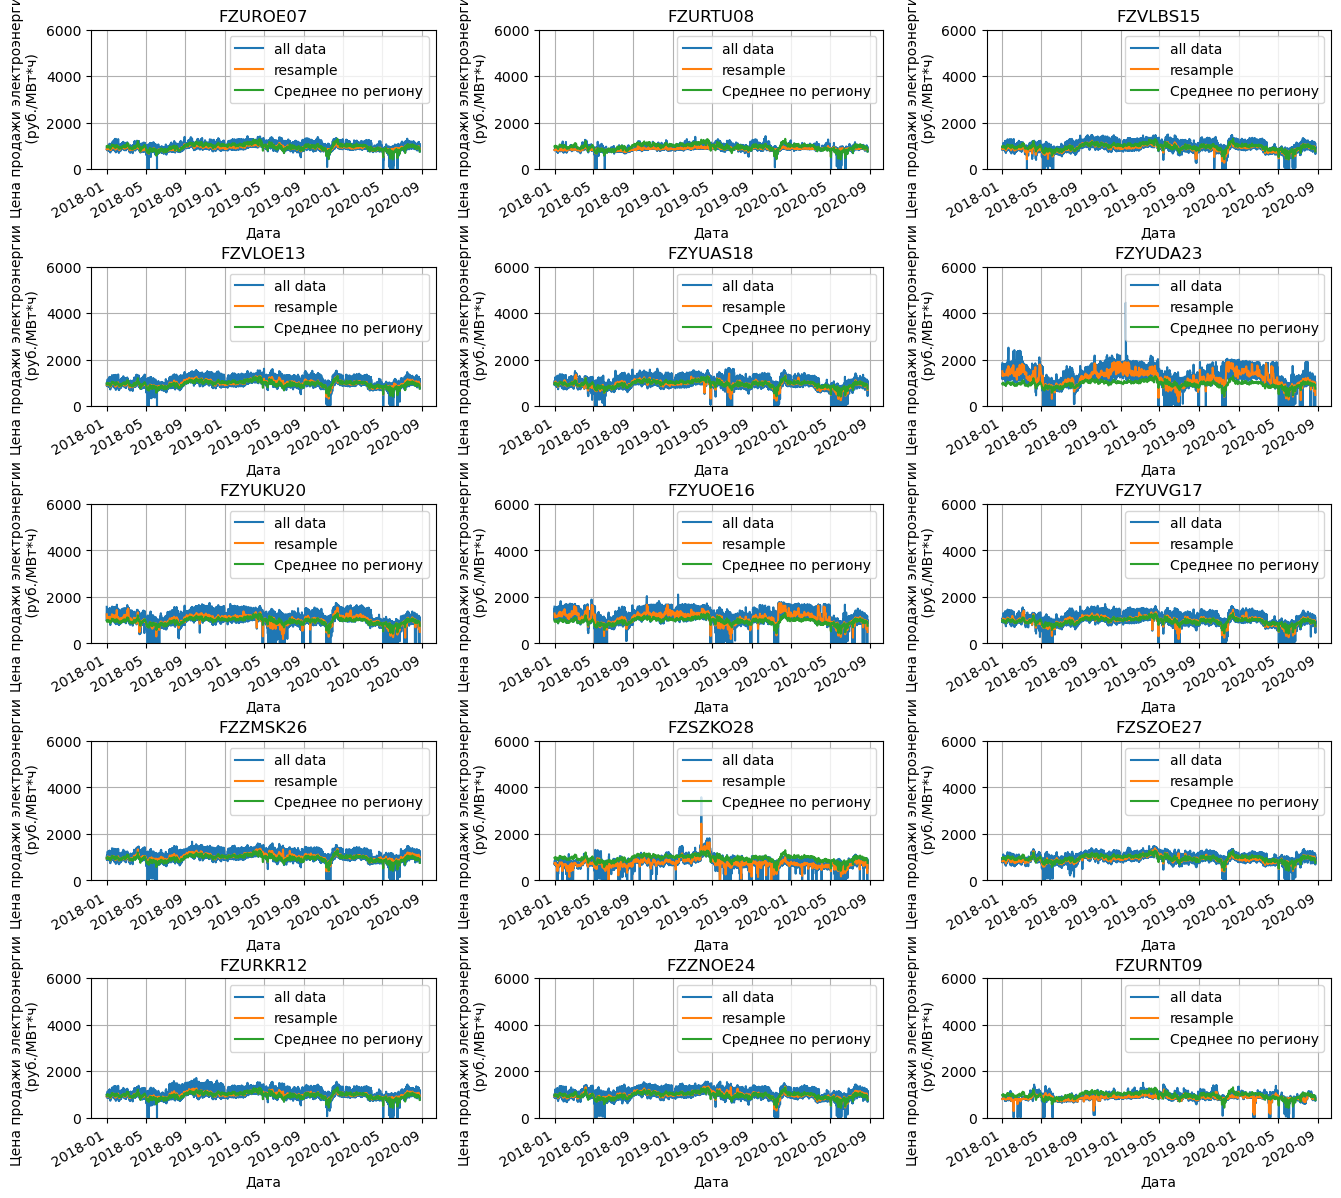

In [31]:
cost_plots(df[df["day_time"] == 0])

Сравним графики с аналогичными для дневного периода.

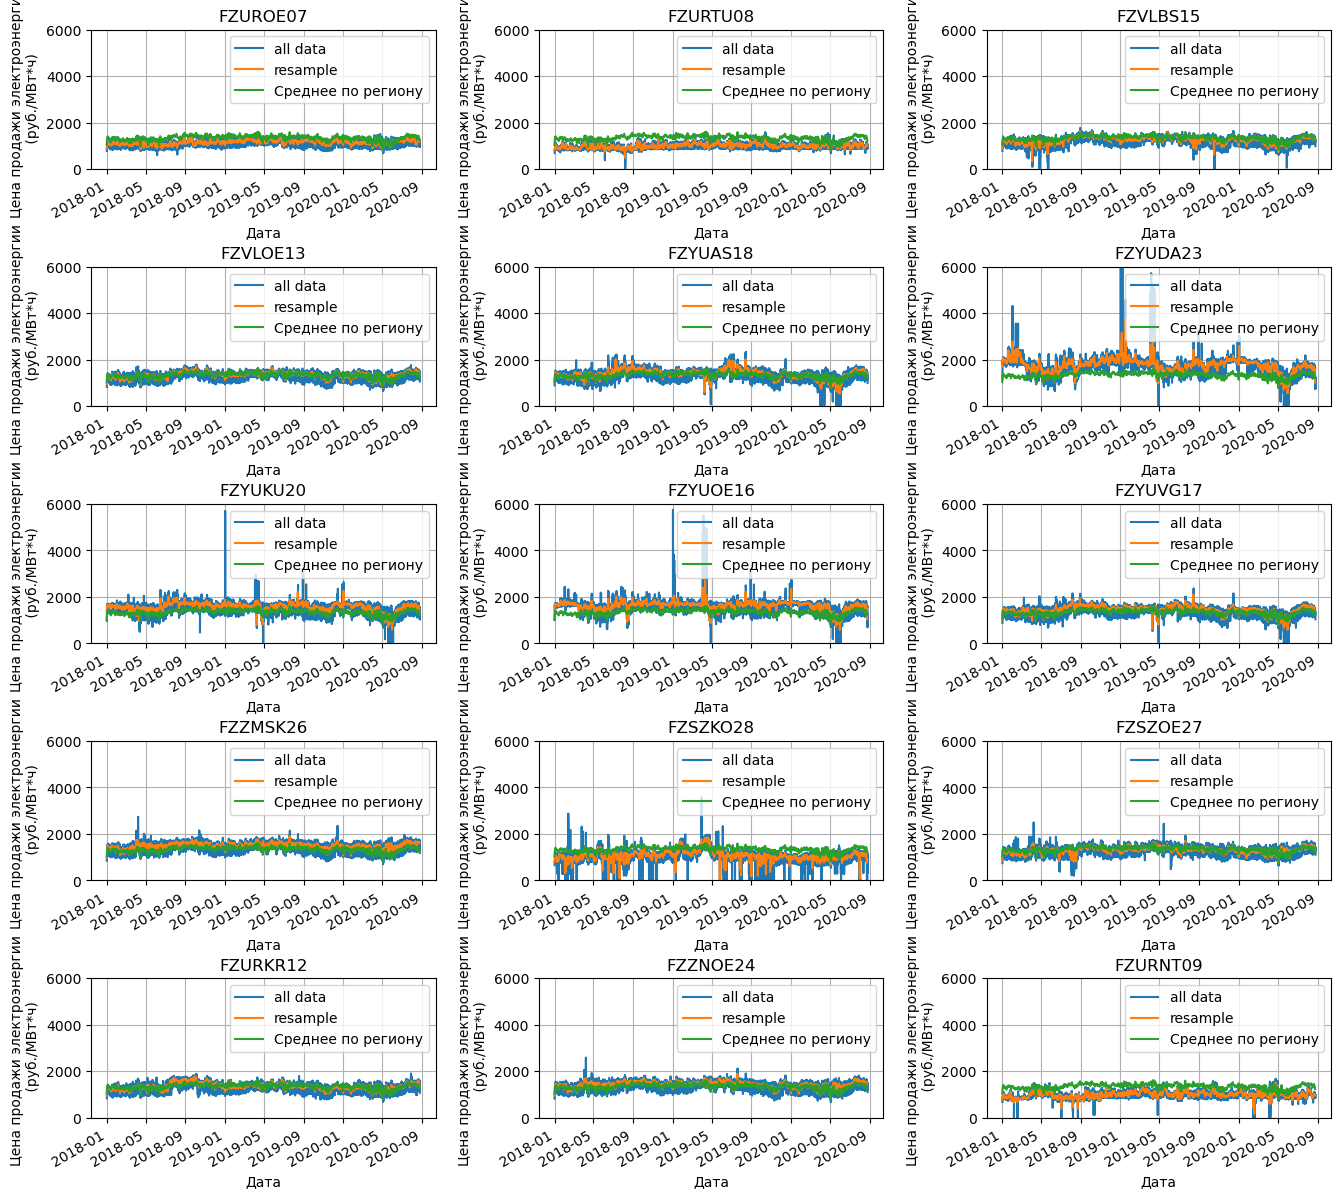

In [32]:
cost_plots(df[df["day_time"] == 1])

Визульано при разделении данных на время суток, графики становятся "глаже".
Для ее численной оценки построим сводную таблицу с расчетом среднего значения и СКО.

In [33]:
# Группируем по ЗСП и времени суток, считая среднее и СКО цены
t = df.groupby(by=["free_overflow_zone", "day_time"])[["cost"]].agg(["mean", "std"])
t.columns = ["mean", "std"]

# Пересоберем полученную таблицу, добавив в нее средние и СКО цен за целый день.

# Сначала вычисленные средние и СКО цен за целый день перенесем в датафрейм
t1 = pd.DataFrame(costs, index=["mean", "std"]).transpose()

# Создаем новый датафрейм, в первой строке которого будут среднее и СКО
# по всему региону
costs_mean_std = t1.loc[["region"]].reset_index()
costs_mean_std["day_time"] = "all_day"
costs_mean_std.columns = costs_mean_std.columns.str.replace(
    "index", "free_overflow_zone"
)
costs_mean_std.loc[1] = [
    "region",
    df[df["day_time"] == 0]["cost"].mean(),
    df[df["day_time"] == 0]["cost"].std(),
    0,
]
costs_mean_std.loc[2] = [
    "region",
    df[df["day_time"] == 1]["cost"].mean(),
    df[df["day_time"] == 1]["cost"].std(),
    1,
]
costs_mean_std = costs_mean_std.set_index("day_time")

# Ниже сама процедура пересобирания. Берем срез по каждому ЗСП и додбавляем в него
# информацию из t1 о цене и ско за весь день. Конкатинируем с итоговой таблицей
for i in t1.drop("region").index:
    t2 = t.loc[i]
    t2.loc["all_day"] = t1.loc[i]
    t2["free_overflow_zone"] = i
    costs_mean_std = pd.concat([costs_mean_std, t2])
costs_mean_std = costs_mean_std.reset_index()
costs_mean_std = costs_mean_std.set_index(["free_overflow_zone", "day_time"])
costs_mean_std

mean         std
free_overflow_zone day_time                         
region             all_day   1210.504163  104.486602
                   0          951.505416  239.149025
                   1         1340.003536  298.294395
FZUROE07           0          920.466684  133.255596
                   1         1148.905724  126.337614
                   all_day   1148.905724   94.968403
FZURTU08           0          868.432695   93.247366
                   1         1002.276037  130.169944
                   all_day   1002.276037  107.816905
FZVLBS15           0          906.007824  185.766335
                   1         1261.380701  172.010621
                   all_day   1261.380701  140.812527
FZVLOE13           0          971.711493  181.201325
                   1         1347.873159  158.160062
                   all_day   1347.873159  124.822746
FZYUAS18           0          930.265404  217.305195
                   1         1386.917217  230.821991
                   all_day   1386.917217  194.609754
FZYUDA23           0         1209.032343  388.023504
                   1         1766.226134  352.555553
                   all_day   1766.226134  295.376580
FZYUKU20           0          989.966737  258.856953
                   1         1553.024437  225.151554
                   all_day   1553.024437  183.241995
FZYUOE16           0         1077.935142  304.307571
                   1         1614.370894  239.839704
                   all_day   1614.370894  187.502966
FZYUVG17           0          960.193441  230.652999
                   1         1433.982719  212.000707
                   all_day   1433.982719  178.305357
FZZMSK26           0         1005.187168  184.747353
                   1         1481.262243  176.138664
                   all_day   1481.262243  132.016859
FZSZKO28           0          729.725863  229.659884
                   1         1060.173476  265.364256
                   all_day   1060.173476  216.083589
FZSZOE27           0          912.829519  171.610659
                   1         1305.900082  170.451705
                   all_day   1305.900082  131.926491
FZURKR12           0          974.005722  168.352170
                   1         1337.918969  171.405442
                   all_day   1337.918969  138.869989
FZZNOE24           0          962.174140  184.082592
                   1         1413.788570  168.297402
                   all_day   1413.788570  128.976746
FZURNT09           0          854.647062  129.630849
                   1          986.052684  167.206030
                   all_day    986.052684  144.072900

Из таблицы видно, что среднее значение ночной цены отличается от дневной - что ожидаемо и видно по гистограммам.
Однако при этом разброс значений, характеризуемый СКО, меньше при определении средней цены за целый день, чем с разделением по времени суток.

В этой связи, в дальнейшем решении не будем учитывать разделение по времени суток.

## Стационарность целевого признака

Ранее отмечалось наличие сезонности в данных. 
Для ее анализа выполним тест Дики-Фуллера, который в качестве нулевой гипотезы проверяет, является ли временной ряд нестационарным и имеет ли он некоторую структуру.
При проведении теста зададимся порогом статистической значимости, равным 0,05.

In [34]:
print(
    "P-value теста Дики-Фуллера для осреднения по всему региону:",
    np.round(adfuller(df["cost"].resample(f"1D").mean())[1], 4),
)

for i in foz_list:
    print(
        f"P-value теста Дики-Фуллера для осреднения по ЗСП {i}:",
        np.round(
            adfuller(
                df.loc[df["free_overflow_zone"] == i, "cost"].resample("1D").mean()
            )[1],
            4,
        ),
    )

P-value теста Дики-Фуллера для осреднения по всему региону: 0.0472
P-value теста Дики-Фуллера для осреднения по ЗСП FZUROE07: 0.0335
P-value теста Дики-Фуллера для осреднения по ЗСП FZURTU08: 0.0033
P-value теста Дики-Фуллера для осреднения по ЗСП FZVLBS15: 0.0309
P-value теста Дики-Фуллера для осреднения по ЗСП FZVLOE13: 0.045
P-value теста Дики-Фуллера для осреднения по ЗСП FZYUAS18: 0.0221
P-value теста Дики-Фуллера для осреднения по ЗСП FZYUDA23: 0.1015
P-value теста Дики-Фуллера для осреднения по ЗСП FZYUKU20: 0.0777
P-value теста Дики-Фуллера для осреднения по ЗСП FZYUOE16: 0.0022
P-value теста Дики-Фуллера для осреднения по ЗСП FZYUVG17: 0.0318
P-value теста Дики-Фуллера для осреднения по ЗСП FZZMSK26: 0.0261
P-value теста Дики-Фуллера для осреднения по ЗСП FZSZKO28: 0.0002
P-value теста Дики-Фуллера для осреднения по ЗСП FZSZOE27: 0.0216
P-value теста Дики-Фуллера для осреднения по ЗСП FZURKR12: 0.0748
P-value теста Дики-Фуллера для осреднения по ЗСП FZZNOE24: 0.0171
P-value те

Из полученных значений видно, что для ЗСП FZYUDA23, FZYUKU20, FZURKR12 p-value больше 0,05.
Это означает, что изменение цены в указанных зонах является нестационарным процессом и имеет зависимости от времени.
В то же время, изменение цены в остальных зонах, а также во всем региона в целом, являются стационарными процессами, а значит, с ними удобнее работать и они лучше прогназируются.

В этой связи, при дальнейшем решении задачи будем рассматривать осредненные данные по всему региону в целом.
Для этого перезапишем исходный датафрейм ресэмплированными значениями.

In [35]:
df = df.resample("1D").mean()

## Распределения остальных признаков

С целевым признаком разобрались.
Теперь посмотрим на распределения остальных признаков и начнем с построения pairplot'a.

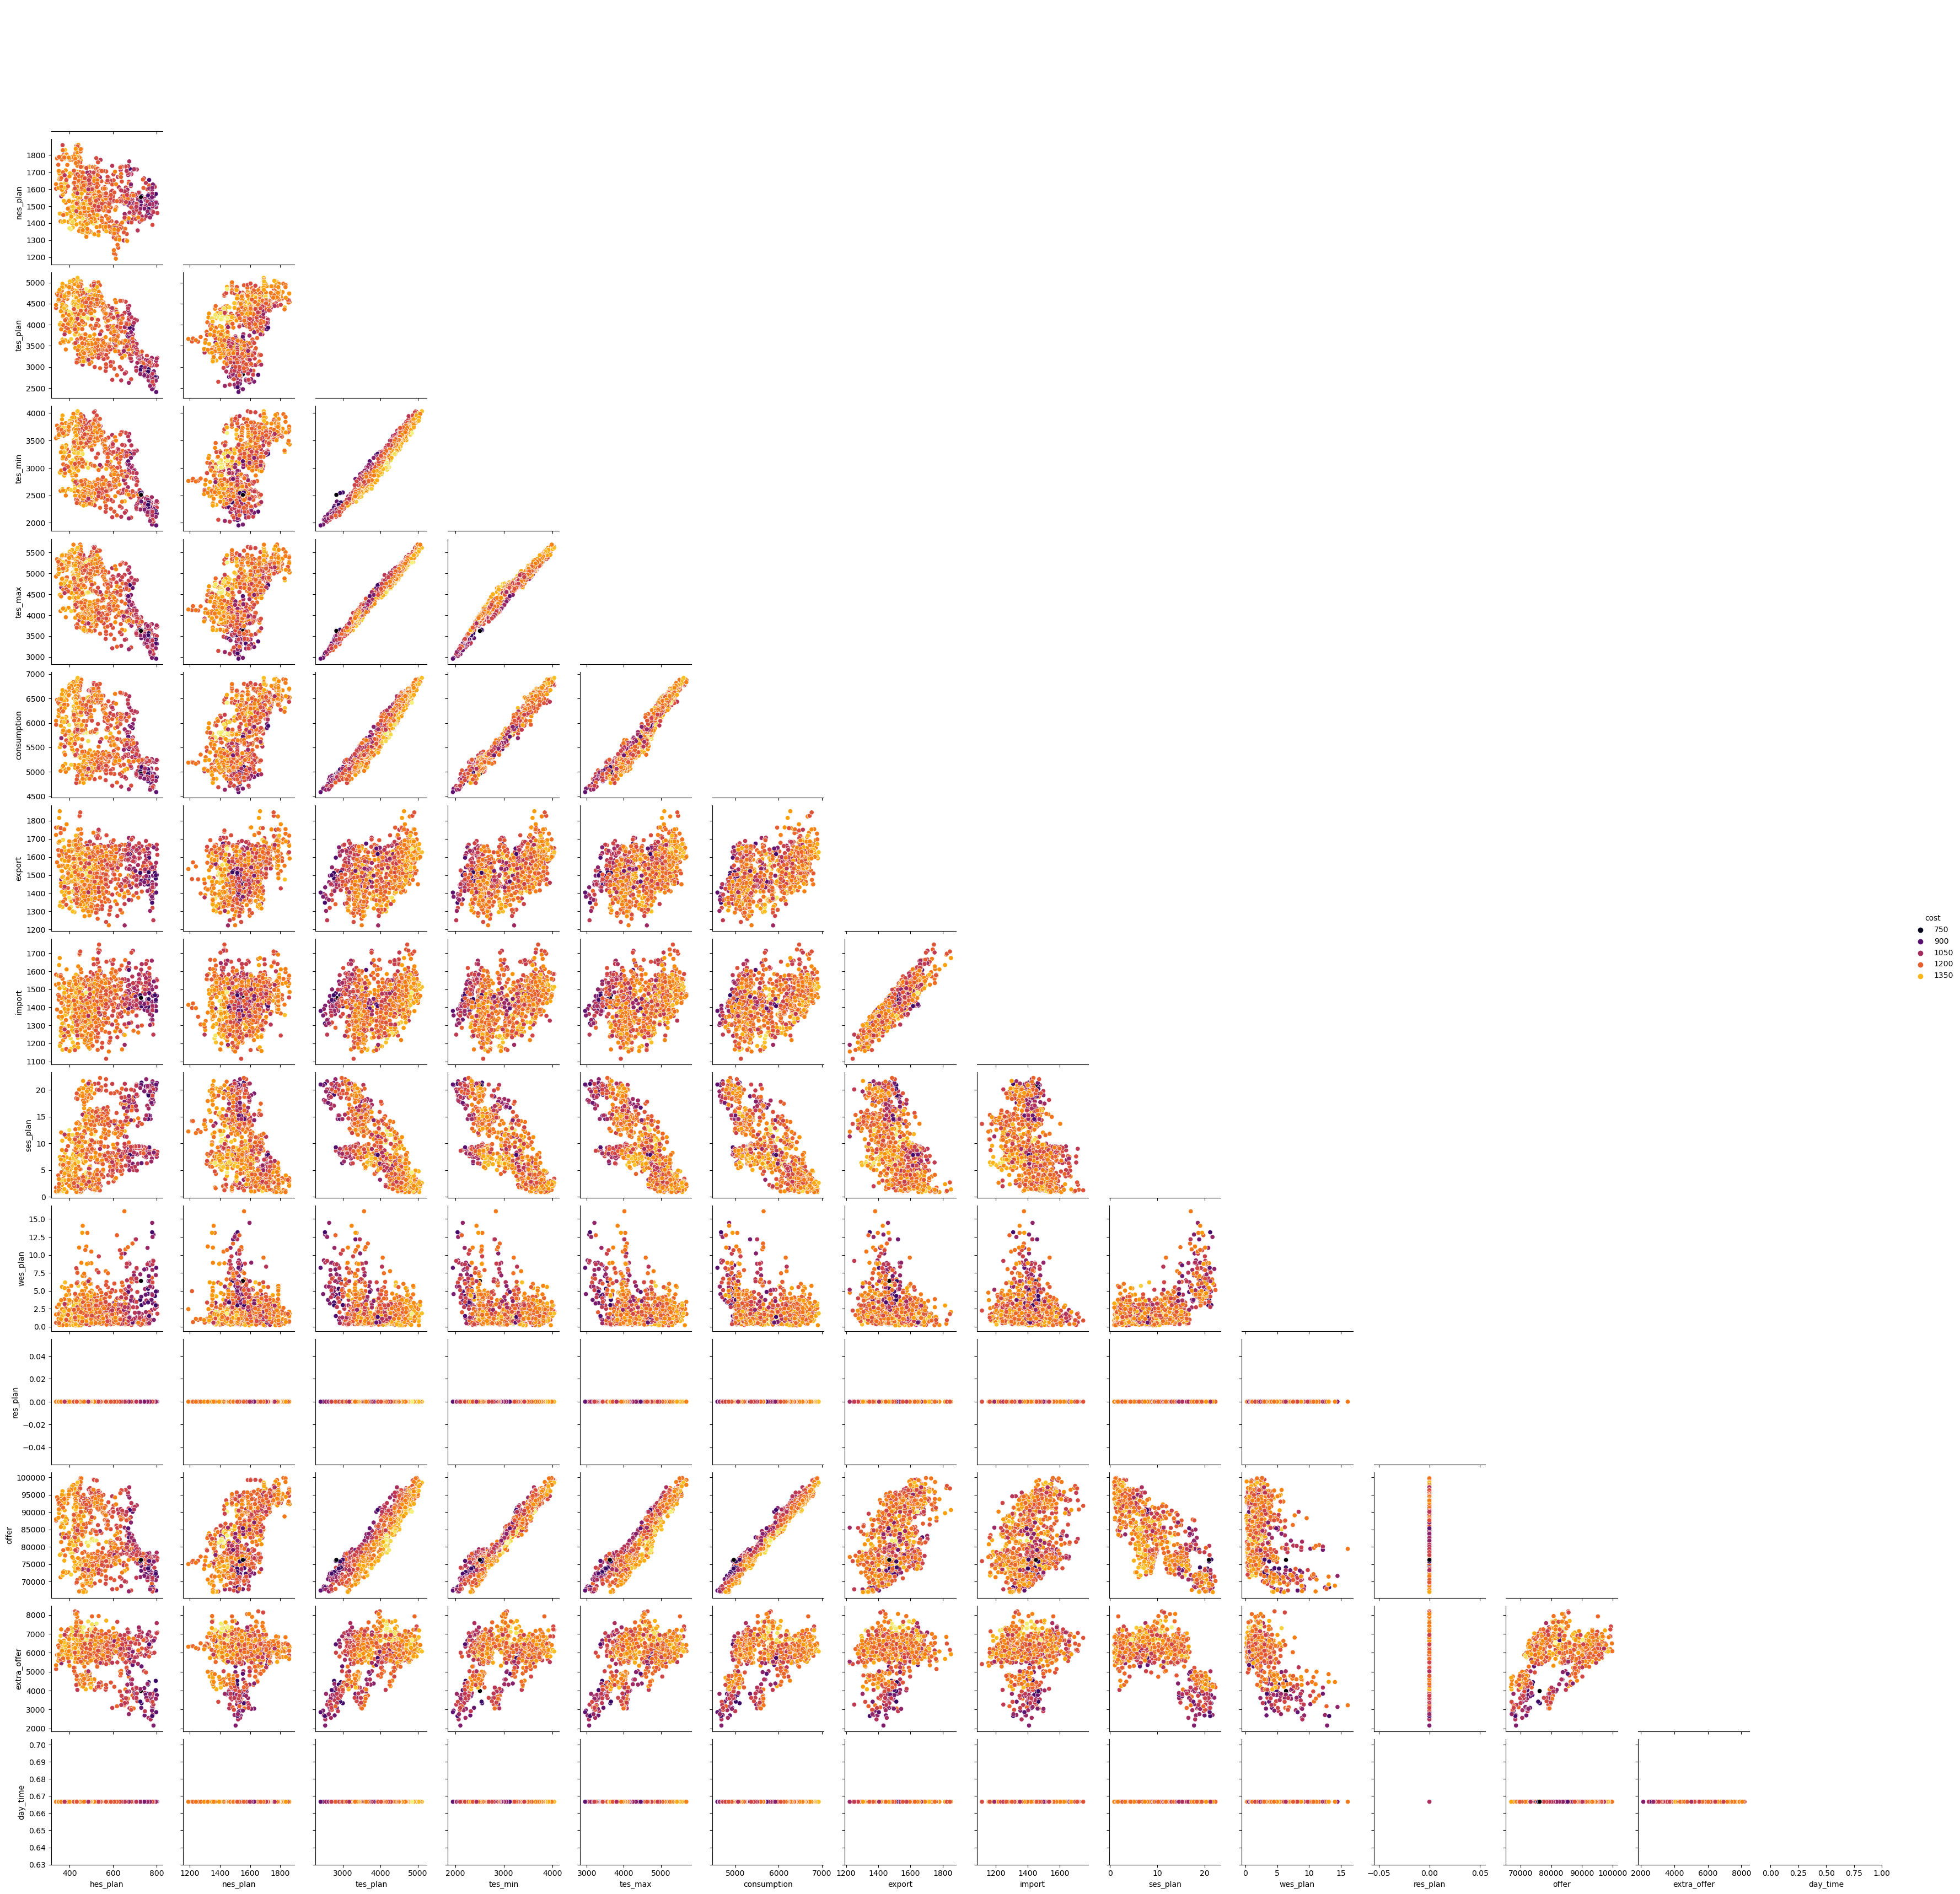

In [36]:
sns.pairplot(df, hue="cost", corner=True, palette="inferno")
plt.show()

По графикм видно следующее:
- Плановая выработка электроэнергии возобновляемыми источниками не изменяется и равна нулю. По всей видимости, это обусловлено отсутсвием соответствующих электростанций в регионе.
- После осреднения информативность созданного признака о времени суток утрачена.
- Для большинства признаков прослеживается визульное разделение по цене электроэнергии, что свидетельствует об их информативности.
- Между признаками ТЭС (мин, макс, план), потребления и ценопринимающим предложением существует взаимосвязь, близкая к линейной. При этом распределение целевого признака по указанным не явное. В этой связи совместное использование указанных признаков при построении линейных моделей без регуляризации будет приводить к неустойчивому решению.

Удалим неинформативные столбцы перечисленные выше.

In [37]:
df = df.drop(columns=["res_plan", "day_time"])

## Стационарность остальных признаков

Проверим наличие структуры в остальных признаках и выведем только те из них, для которых значение p-value больше порога 0,05.

In [38]:
dickey_fuller_p = []

for i in df.drop(
    ["cost"],
    axis=1,
).columns:
    dickey_fuller_p.append(np.round(adfuller(df[i])[1], 4))
    print(f"P-value теста Дики-Фуллера признака {i}:", dickey_fuller_p[-1])

pv = pd.DataFrame(
    {"p-value": dickey_fuller_p},
    index=df.drop(
        ["cost"],
        axis=1,
    ).columns,
).sort_values(by="p-value", ascending=False)
pv[pv["p-value"] > 0.05]

P-value теста Дики-Фуллера признака hes_plan: 0.0464
P-value теста Дики-Фуллера признака nes_plan: 0.0007
P-value теста Дики-Фуллера признака tes_plan: 0.1918
P-value теста Дики-Фуллера признака tes_min: 0.1556
P-value теста Дики-Фуллера признака tes_max: 0.1986
P-value теста Дики-Фуллера признака consumption: 0.1977
P-value теста Дики-Фуллера признака export: 0.0086
P-value теста Дики-Фуллера признака import: 0.0861
P-value теста Дики-Фуллера признака ses_plan: 0.737
P-value теста Дики-Фуллера признака wes_plan: 0.5688
P-value теста Дики-Фуллера признака offer: 0.2833
P-value теста Дики-Фуллера признака extra_offer: 0.3658


p-value
ses_plan      0.7370
wes_plan      0.5688
extra_offer   0.3658
offer         0.2833
tes_max       0.1986
consumption   0.1977
tes_plan      0.1918
tes_min       0.1556
import        0.0861

Из таблицы видно, что 9 признаков имеют структуру в данных.

Визуализируем эти признаки, их сезонность, тренд и шум. 

In [39]:
def feature_season_trend(df, feature, ax_pure, ax_s, ax_t, ax_n):
    """
    Функция принимает датафрейм, название фичи и адреса графиков
    для сабплота.
    Внутри происходит декомпозиция значений и построение графиков по ним.
    """
    feature_decomposed = seasonal_decompose(df)

    # График признака
    df.plot(ylabel="Объем э/энергии, МВт*ч", xlabel="Дата", ax=ax_pure)
    ax_pure.set_title(f"Чистый {feature}")
    ax_pure.grid(axis="y")

    # График сезонности
    feature_decomposed.seasonal.plot(
        ylabel="Объем э/энергии, МВт*ч", xlabel="Дата", ax=ax_s
    )
    ax_s.set_title(f"Сезонность {feature}")
    ax_s.set_xlim("2018-01-01", "2018-02-01")
    ax_s.grid(axis="y")

    # График тренда
    feature_decomposed.trend.plot(
        ylabel="Объем э/энергии, МВт*ч", xlabel="Дата", ax=ax_t
    )
    ax_t.set_title(f"Тренд {feature}")
    ax_t.grid(axis="y")

    # График шума
    feature_decomposed.resid.plot(
        ylabel="Объем э/энергии, МВт*ч", xlabel="Дата", ax=ax_n
    )
    ax_n.set_title(f"Шум {feature}")
    ax_n.grid(axis="y")

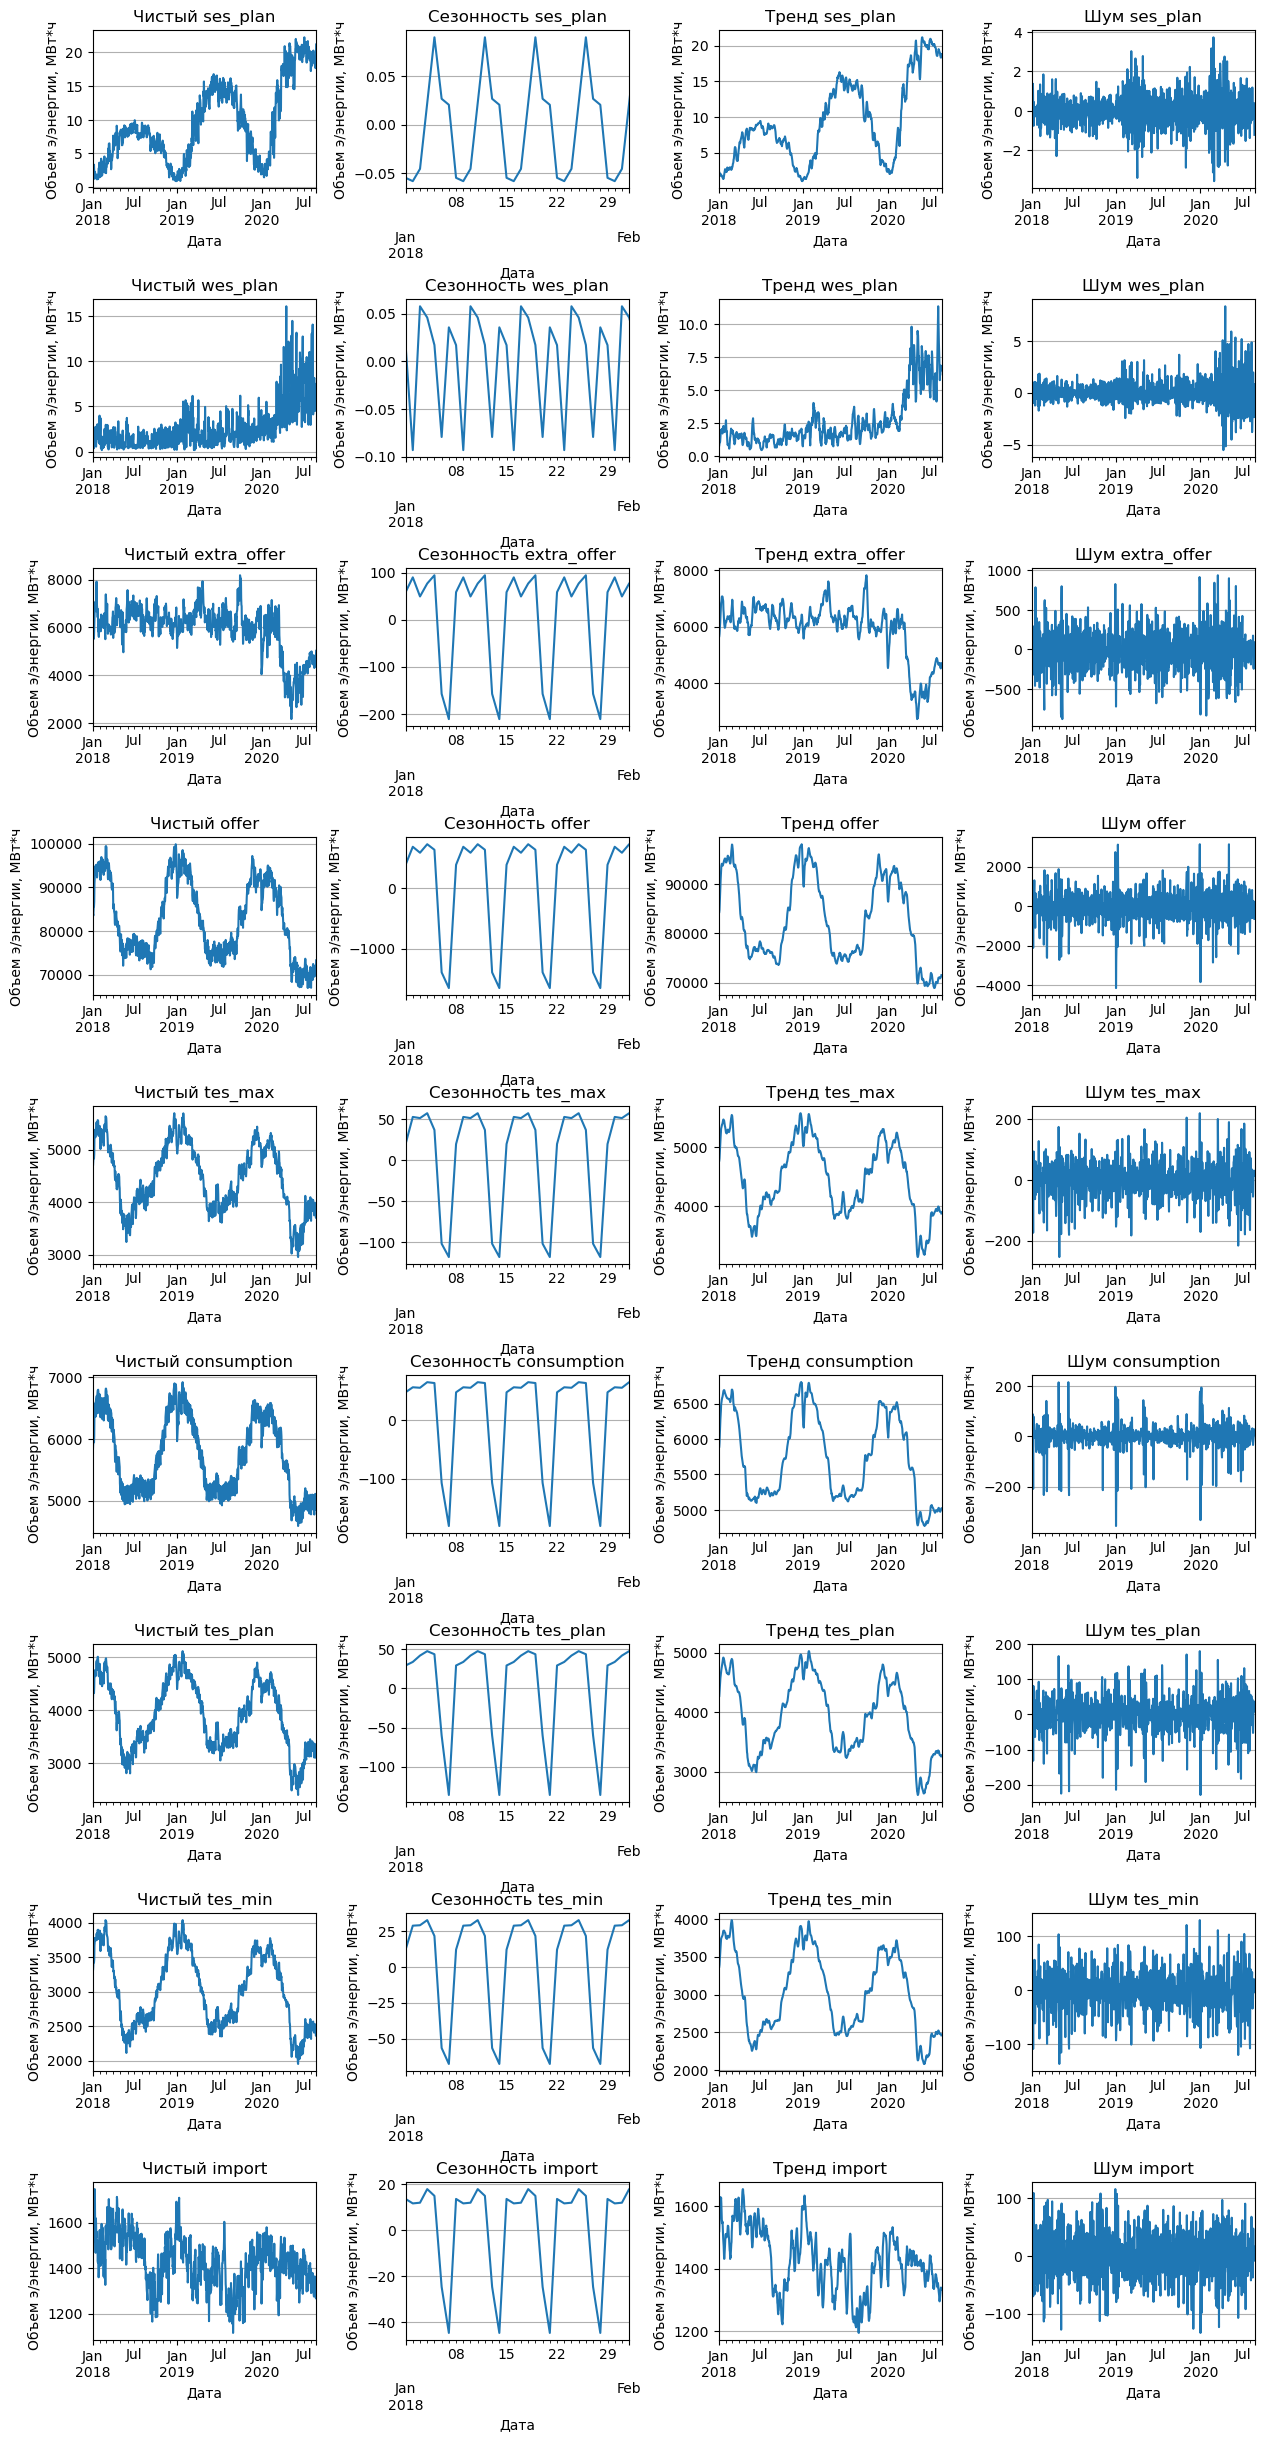

In [40]:
# Сохраняем нестационарные признаки в лист
nostat_features = pv[pv["p-value"] > 0.05].index

_, axs = plt.subplots(len(nostat_features), 4, figsize=(15, 30))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

# Перебираем каждый признак и строим графики
for i in range(len(nostat_features)):
    feature_season_trend(
        df[nostat_features[i]],
        feature=nostat_features[i],
        ax_pure=axs[i, 0],
        ax_s=axs[i, 1],
        ax_t=axs[i, 2],
        ax_n=axs[i, 3],
    )

plt.show()

По построенным графикам видно, что амплитуда сезонности и шума в признаках менее 1% от их номианльного значения.
В то же время тренд имеет периодичность, что ограничивает использование приведенных признаков.

Для преобразования признаков в стационарный вид воспользуемся дифференцированием.

P-value теста Дики-Фуллера модифицированного признака 0: 0.0
P-value теста Дики-Фуллера модифицированного признака 1: 0.0
P-value теста Дики-Фуллера модифицированного признака 2: 0.0
P-value теста Дики-Фуллера модифицированного признака 3: 0.0
P-value теста Дики-Фуллера модифицированного признака 4: 0.0
P-value теста Дики-Фуллера модифицированного признака 5: 0.0
P-value теста Дики-Фуллера модифицированного признака 6: 0.0
P-value теста Дики-Фуллера модифицированного признака 7: 0.0
P-value теста Дики-Фуллера модифицированного признака 8: 0.0


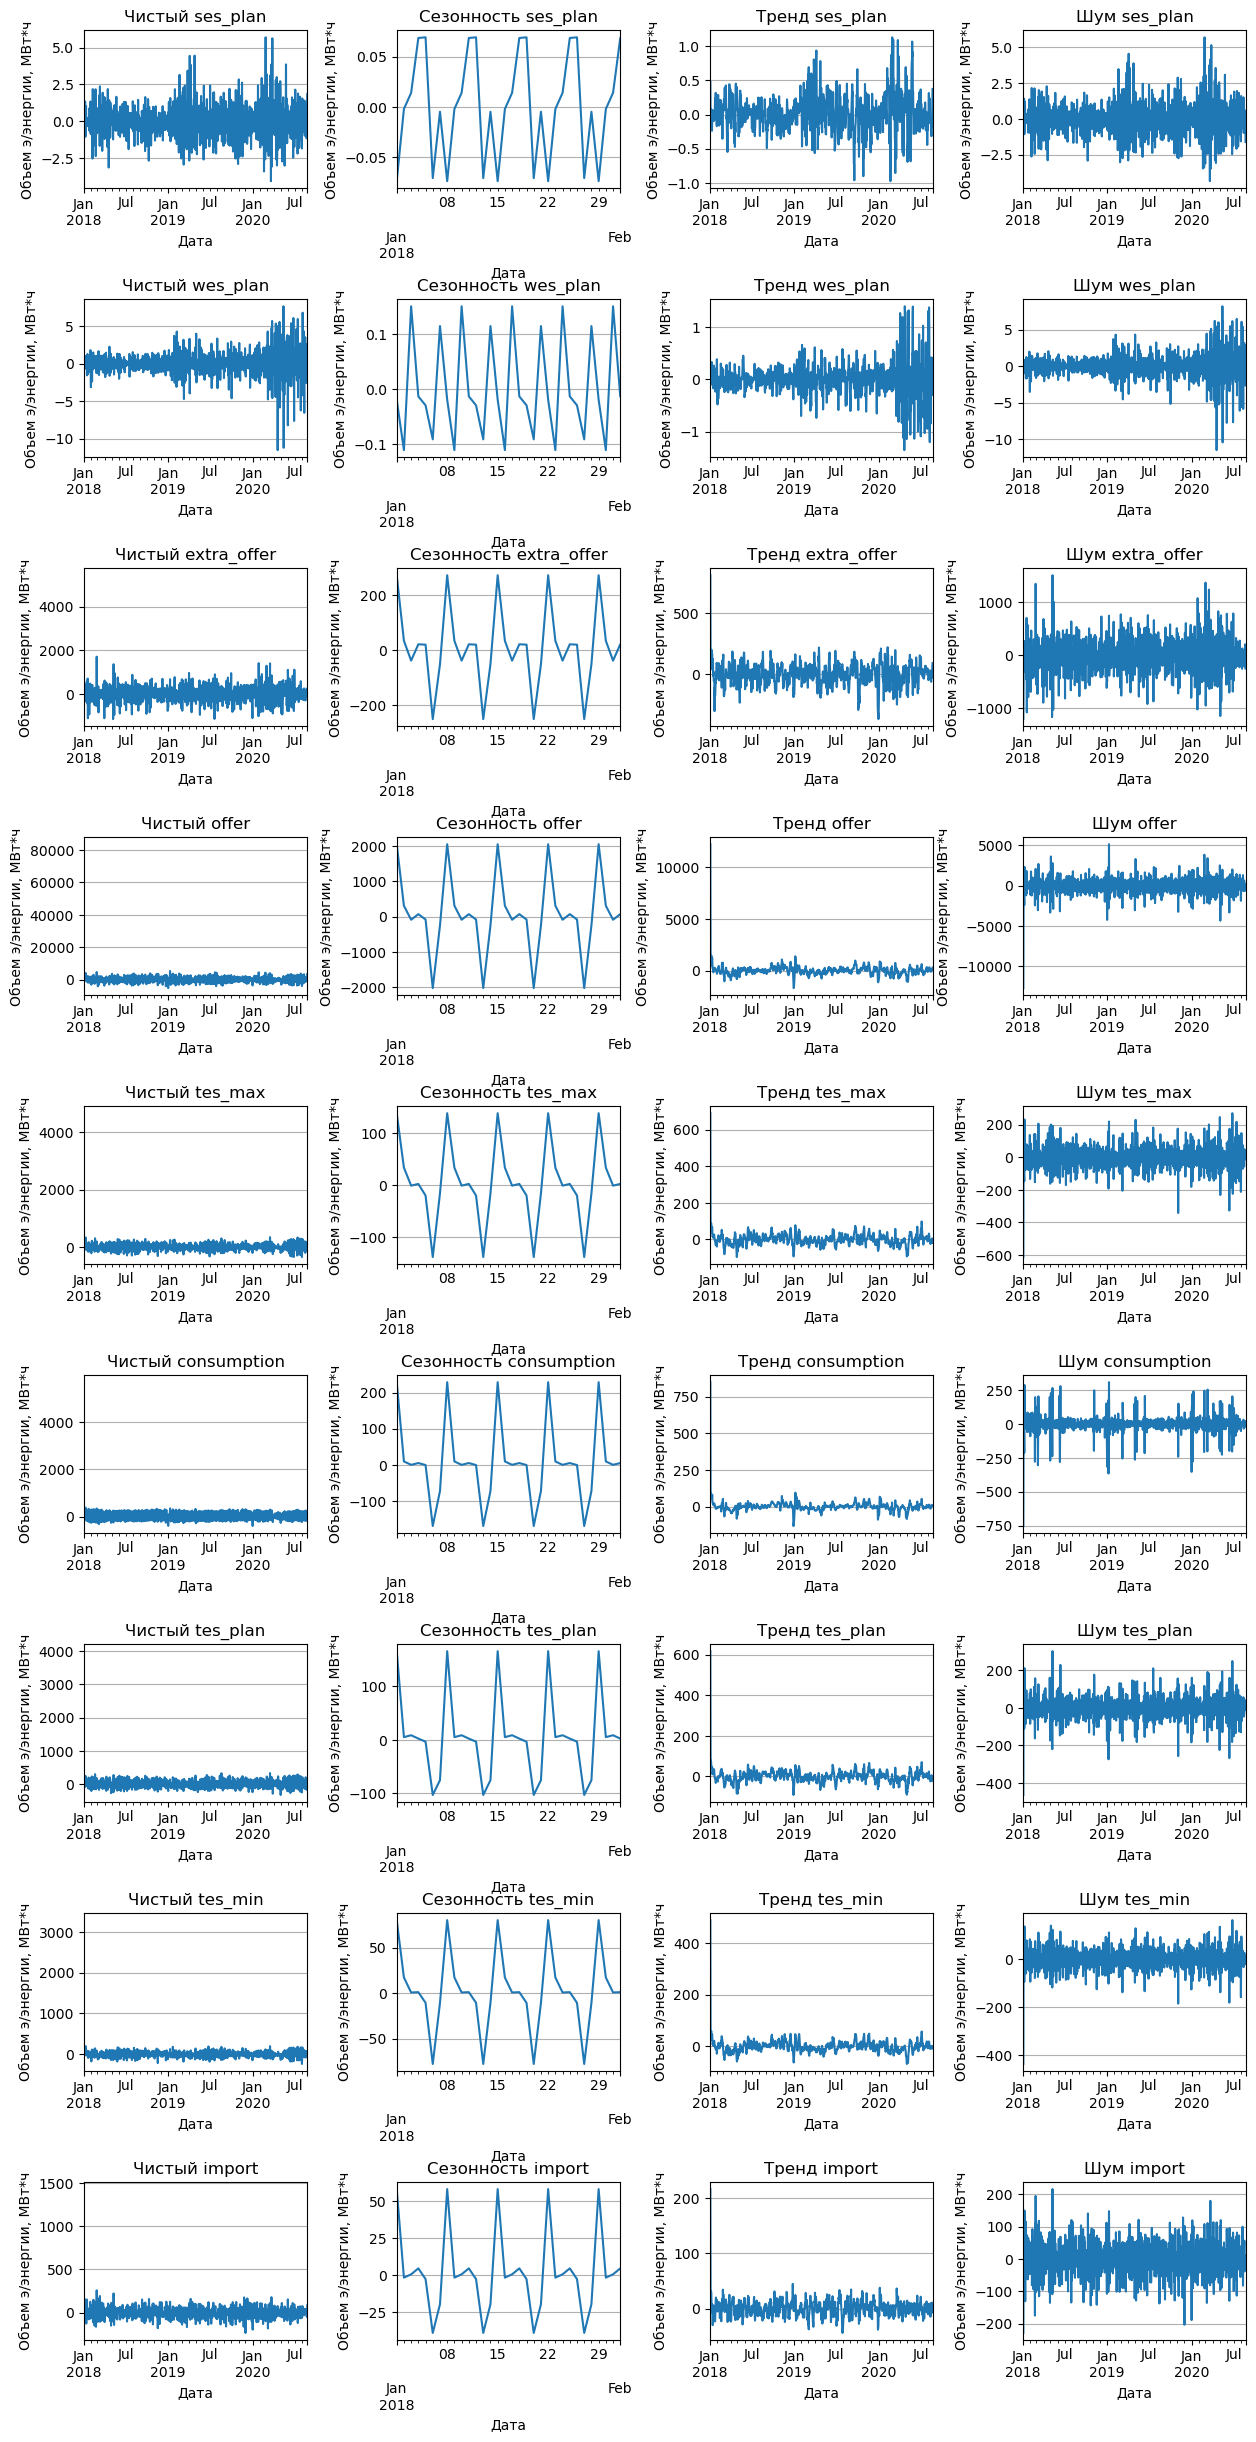

In [41]:
_, axs = plt.subplots(len(nostat_features), 4, figsize=(15, 30))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

for i in range(len(nostat_features)):
    df["new_feature"] = np.diff(df[nostat_features[i]], prepend=0)
    feature_season_trend(
        df["new_feature"],
        feature=nostat_features[i],
        ax_pure=axs[i, 0],
        ax_s=axs[i, 1],
        ax_t=axs[i, 2],
        ax_n=axs[i, 3],
    )
    axs[i, 1].set_xlim("2018-01-01", "2018-02-01")

    print(
        f"P-value теста Дики-Фуллера модифицированного признака {i}:",
        np.round(adfuller(df["new_feature"])[1], 4),
    )

df = df.drop(columns="new_feature")
plt.show()

P-value для все признаков теперь равно нулю, а периодичность в тренде нивелирована.
Цель достигнута, сохраним преобразовния в датафрейм.

In [42]:
for i in nostat_features:
    df[nostat_features] = np.diff(df[nostat_features], prepend=0)

df = df.drop("2018-01-01")

## Корреляции признаков

Построим матрицу корреляции признаков при помощи библиотеки phik, учитывающей нелинейные взаимосвязи в данных.

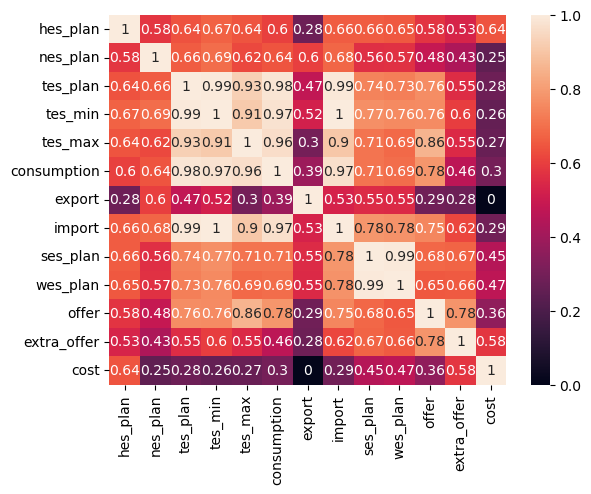

In [43]:
phik = df.phik_matrix(bins=30, verbose=False)

sns.heatmap(phik, annot=True)
plt.show()

Как отмечалось ранее, для между признаками ТЭС (мин, макс, план), потребления и ценопринимающим предложением существует мультиколлинеарность.
Однако, согласно построенному хитмэпу, к этому перечню признаков добавляется еще их взаимосвязь с импортом, а также связка планов СЭС и ВЭС.

В то же время, экспорт не оказывает влияния на цену электроэнергии, в связи с чем исключим его из дальнейшего решения.

In [44]:
df = df.drop(columns="export")

# Моделирование

В соответствии с анализом данных выявлено, что изменение цены электроэнергии - стационарный процесс. 
Другими словами, она не имеет зависимость от времени, а применение библиотек машинного обучения, заточенных под времянные ряды (ARIMA, Prophet), не дает значимого результата.

В этой связи, для построения прогноза будем использовать два типа моделей: градиентный бустинг (catboost) и линейную.
При этом, учитывая наличие мультиколлинеарности последнюю модель будем использовать с регуляризацией (Ridge/Lasso).

В качестве метрики качества предсказаний моделей используем корень из среднеквадратической ошибке (rmse).

## Подготовка данных

In [45]:
# Переменная для random_seed
SEED = 26

# Целевой признак
y = ["cost"]

# Лист остальных признаков
X = df.drop(columns=["cost"]).columns.tolist()

# Разбиене на обучение / валидацию / тест
train = df.head(-60)
val = df.tail(60).head(30)
test = df.tail(30)

len(train), len(val), len(test)

(906, 30, 30)

Учитывая применение линейных моделей, применим стандартизацию признаков.

In [46]:
ss = StandardScaler()

for i in X:
    train[i] = ss.fit_transform(train[[i]])
    val[i] = ss.transform(val[[i]])
    test[i] = ss.transform(test[[i]])

## Baseline

Для анализа качества предсказаний моделей, создадим baseline в виде осредненного значения целевого признака на тестовом наборе данных.

In [47]:
val["pred_mean"] = train[y].mean()[0]
mse_bl = mean_squared_error(val[y], val["pred_mean"], squared=False)
mse_bl

74.30847876471405

Получено значение.  
На фоне среднего значения цены электроэнергии около 1200, кажется, что точность вполне приемлемая.

## Catboost

In [48]:
train_pool = Pool(data=train[X], label=train[y])
val_pool = Pool(data=val[X], label=val[y])

init_params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 26,
    "has_time": True,
    "early_stopping_rounds": 200,
}

model_cbr = CatBoostRegressor(**init_params, learning_rate=0.05, verbose=250)
model_cbr.fit(train_pool, eval_set=val_pool)

0:	learn: 103.5982528	test: 72.8836328	best: 72.8836328 (0)	total: 51.3ms	remaining: 51.3s
250:	learn: 43.6791545	test: 46.7882684	best: 44.5876220 (176)	total: 233ms	remaining: 696ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 44.58762201
bestIteration = 176

Shrink model to first 177 iterations.


Полученное значение почти в 2 раза лучше бэйзлайна.  
Попробуем его улучшить, оптимизировав при помощи библиотеки optuna глубину деревьев и learning rate.

In [49]:
def optuna_cbr(
    train_pool, val_pool, n_trials=10, init_params=None, first_iteration=None
):
    """
    Функция получает pool_catboost для обучения и валидации,
    количество итераций оптимизации,
    начальные параметры моделирования, начальную точку оптимизации.
    Внутри объявляется функция оптимизации Optun'ы и сам расчет.
    """

    def objective_cbr(trial):
        params_optuna = {
            "learning_rate": trial.suggest_float(
                "learning_rate", 0.001, 0.5, step=0.0001
            ),
            "depth": trial.suggest_int("depth", 1, 16),
        }

        if init_params:
            params_optuna.update(init_params)

        cbr_optuna = CatBoostRegressor(**params_optuna, verbose=False)
        cbr_optuna.fit(train_pool, eval_set=val_pool)

        return cbr_optuna.get_best_score()["validation"]["RMSE"]

    study_cbr = optuna.create_study(
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(seed=SEED) # Повторяемость
    )

    if first_iteration:
        study_cbr.enqueue_trial({**first_iteration})

    study_cbr.optimize(objective_cbr, n_trials=n_trials, show_progress_bar=True)

    return study_cbr

In [50]:
# Отключаем вывод на экран
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

first_iteration = {"learning_rate": 0.2507, "depth": 3}

optuna_res = optuna_cbr(
    train_pool,
    val_pool,
    300,
    init_params=init_params,
    first_iteration=first_iteration,
)

  0%|          | 0/300 [00:00<?, ?it/s]

Посмотрим лучшие параметры.

In [51]:
best_params = optuna_res.best_params
best_params

{'learning_rate': 0.2507, 'depth': 3}

Проведем обучение на лучших параметрах и посмотри на значимость признаков.

In [52]:
model_cbr = CatBoostRegressor(**best_params, **init_params, verbose=250)
model_cbr.fit(train_pool, eval_set=val_pool)
val["pred_cbr"] = model_cbr.predict(val[X])

pd.DataFrame({"feature": X, "score": model_cbr.feature_importances_}).sort_values(
    by="score", ascending=False
)

0:	learn: 94.8768870	test: 66.8074851	best: 66.8074851 (0)	total: 1.22ms	remaining: 1.22s
250:	learn: 35.7436431	test: 49.2179942	best: 31.8737764 (69)	total: 133ms	remaining: 397ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 31.87377641
bestIteration = 69

Shrink model to first 70 iterations.


feature      score
0      hes_plan  54.428842
1      nes_plan  12.782020
10  extra_offer   5.457957
8      wes_plan   5.405883
7      ses_plan   5.123259
3       tes_min   4.525572
9         offer   4.302283
6        import   3.272169
5   consumption   2.262151
2      tes_plan   1.515193
4       tes_max   0.924672

Из таблицы хорошо видно, что все признаки значимы, а зашумленность данных минимальная.

Визуализируем предсказанное решение.

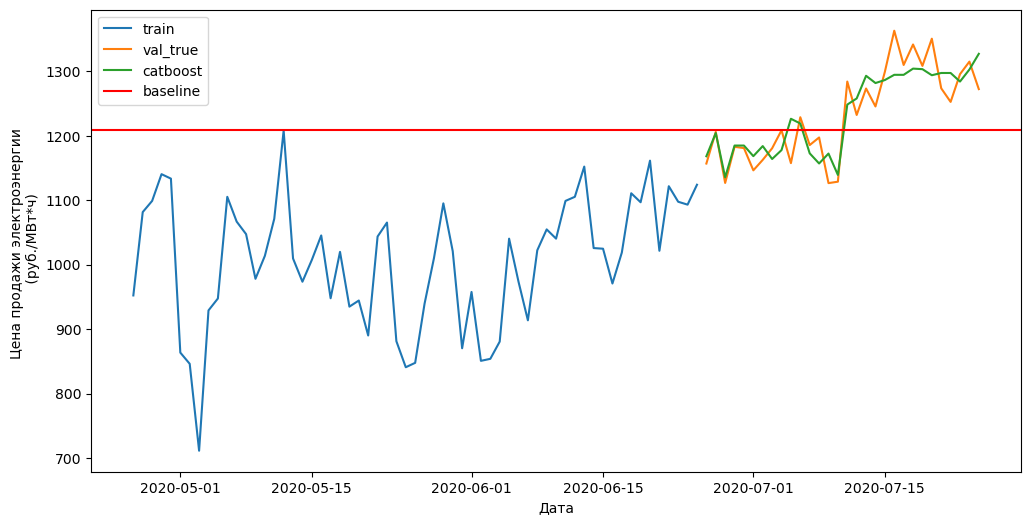

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(train["2020-04-26":][y], label="train")
plt.plot(val[["cost", "pred_cbr"]], label=["val_true", "catboost"])
plt.axhline(train[y].mean()[0], color="r", label="baseline")
plt.ylabel("Цена продажи электроэнергии \n (руб./МВт*ч)")
plt.xlabel("Дата")
plt.legend()
plt.show()

Видно, что catboost достаточно хорошо предсказывает целевую переменную.

## Линейная регрессия

При предварительном решении задачи, получено, что лучший результат среди линейных моделей дает модель с регуляризацией Ridge.

In [54]:
model_ridge = Ridge()
model_ridge.fit(train[X], train[y])

mean_squared_error(val[y], model_ridge.predict(val[X]), squared=False)

50.96707287448201

Полученное значение лучше baseline, но хуже catboost.
Проведем оптимизацию optun'ой, поситаем RMSE и построим графики.

In [55]:
def optuna_ridge(train_X, train_y, val_X, val_y, n_trials=10):
    """
    Функция получает выборки обучения и валидации,
    и количество итераций оптимизации.
    Внутри объявляется функция оптимизации Optun'ы и сам расчет.
    """

    def objective_ridge(trial):
        params = {
            "alpha": trial.suggest_float("alpha", 0, 1, step=0.001),
            "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
            "random_state": SEED,
            "positive": trial.suggest_categorical("positive", [True, False]),
        }

        if params["positive"] == True:
            params["solver"] = "lbfgs"
        else:
            params["solver"] = trial.suggest_categorical(
                "solver",
                [
                    "auto",
                    "svd",
                    "cholesky",
                    "lsqr",
                    "sparse_cg",
                    "sag",
                    "saga",
                ],
            )

        model_ridge = Ridge(**params)
        model_ridge.fit(train_X, train_y)

        return mean_squared_error(val_y, model_ridge.predict(val_X), squared=False)

    study_ridge = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=SEED),
    )
    study_ridge.optimize(objective_ridge, n_trials=n_trials, show_progress_bar=True)

    return study_ridge

In [56]:
optuna_ridge_res = optuna_ridge(train[X], train[y], val[X], val[y], n_trials=300)

  0%|          | 0/300 [00:00<?, ?it/s]

In [57]:
best_params_ridge = optuna_ridge_res.best_params
best_params_ridge

{'alpha': 0.0, 'fit_intercept': True, 'positive': False, 'solver': 'auto'}

In [58]:
model_ridge = Ridge()
model_ridge.fit(train[X], train[y])
val["pred_lin"] = model_ridge.predict(val[X])

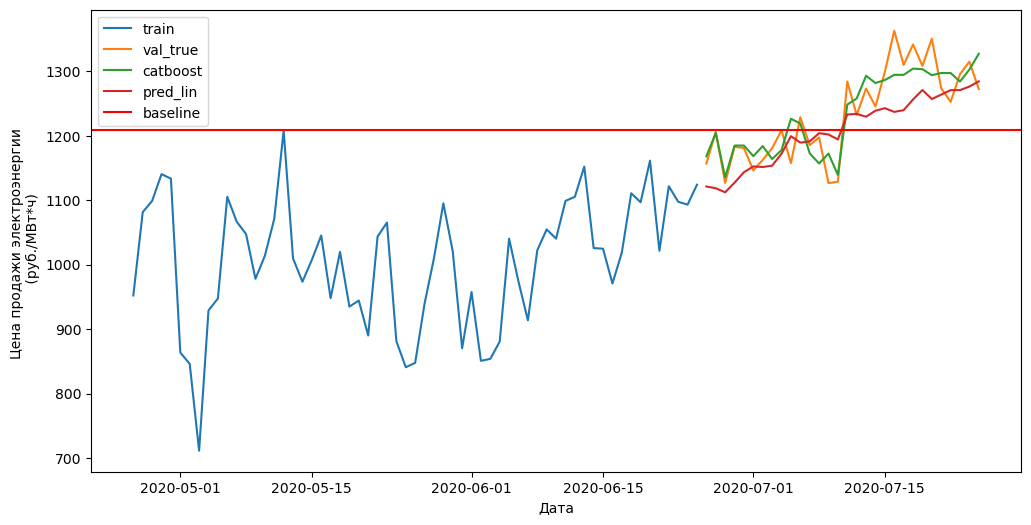

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(train["2020-04-26":][y], label="train")
plt.plot(
    val[["cost", "pred_cbr", "pred_lin"]], label=["val_true", "catboost", "pred_lin"]
)
plt.axhline(train[y].mean()[0], color="r", label="baseline")
plt.ylabel("Цена продажи электроэнергии \n (руб./МВт*ч)")
plt.xlabel("Дата")
plt.legend()
plt.show()

RMSE линейной модели чуть хуже аналогичного для catboost.

Тем не менее, стоит иметь ввиду, что такой результат получен при значении параметра *aplha*, равном 0. 
Последнее говорит об отсутсвии регуляризации признаков.
Учитывая наличие мультиколлинеарности в данных, такое значение метрики может быть нестабильным, а RMSE модели будет увеличиваться временем.

В этой связи в качестве наиболее подходящей модели машинного обучения для решения поставленной задачи является catboost.

## Тест

Перед тестированием дообучим модель на валидационной выборке.  
После выведем итоговое RMSE.

In [60]:
model_cbr.fit(val_pool, init_model=model_cbr)
test["pred_cbr"] = model_cbr.predict(test[X])
mean_squared_error(test[y], test["pred_cbr"], squared=False)

0:	learn: 30.4824626	total: 170us	remaining: 170ms
250:	learn: 0.0291946	total: 26.3ms	remaining: 78.5ms
500:	learn: 0.0000843	total: 52ms	remaining: 51.8ms
750:	learn: 0.0000004	total: 78.2ms	remaining: 25.9ms
999:	learn: 0.0000000	total: 105ms	remaining: 0us


44.334066772421814

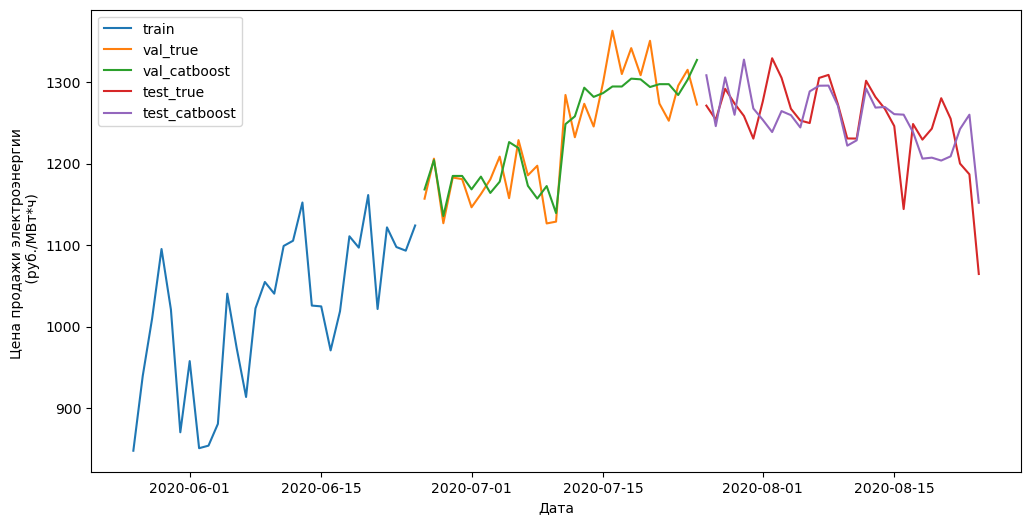

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(train["2020-05-26":][y], label="train")
plt.plot(val[["cost", "pred_cbr"]], label=["val_true", "val_catboost"])
plt.plot(test[["cost", "pred_cbr"]], label=["test_true", "test_catboost"])
plt.ylabel("Цена продажи электроэнергии \n (руб./МВт*ч)")
plt.xlabel("Дата")
plt.legend()
plt.show()

Значение RMSE на тестовой выборке ухудшилось на 12 единиц, что может говорить о переобучении модели.
Визуально модель catboost достаточно хорошо повторяет настоящие данные.

# Заключение

В результате работы загружены и исследованы данные о стоимости электроэнергии в Европейском регионе России.

Анализ данных показал, что изменение стоимости является стационарным процессом и не зависит в явном виде от времени.
Большинство вторичных признаков так же обладают стационарностью.
Однако признаки ТЭС (план, мин, макс), планов СЭС, ВЭС, ценопринимающего предложения, ценопринимания сверх минимальной мощности, потребления и импорта являются нестационарными и имеют структуру.
Последняя проявляется в виде изменьчивости тренда.

Перед моделированием нестационарность признаков нивелирована путем дифференцирования их значений.
Само моделирвоание проведено с использованием градиентного бустинга (Catboost) и линейной регрессии с регуляризацией (Ridge).
Гиперпараметры моделей оптимизированы при помощи библиотеки Optuna.
В качестве отправной точки моделирования (baseline) использовано среднее значение цены на обучающей выборке.
Качество моделей оценивалось вычислением корня из среднеквадратической ошибке (RMSE)

В результате подбора гиперпараметров получены следующие значения  
$ RMSE_{baseline} = 74.3 $ $ руб/(МВт\cdotч); $
$ RMSE_{catboost} = 31.9$ $ руб/(МВт\cdotч); $
$ RMSE_{ridge} = 32.4$ $ руб/(МВт\cdotч); $

На фоне среднего значения цены электроэнергии около 1200, полученные значения представляются допустимыми.
Стоит отметить, что метрика Ridge регрессии получено при отключенной регуляризации, что, в силу наличия мультиколлинеарности в данных, делает решение неустойчивым к дальнейшим изменениям.

В качестве наиболее подходящей модели машинного обучения для решения поставленной задачи выбран Сatboost.
На тестовой подвыборке получено значение 
$ RMSE_{test} = 44.2$ $ руб/(МВт\cdotч). $